# Day 4: Correlation, Covariance & Factor Analysis

## Week 1 - Python for Quantitative Finance

### 🎯 Learning Objectives
- Compute and interpret correlation and covariance matrices
- Understand the relationship between correlation and portfolio risk
- Apply PCA for factor analysis
- Analyze rolling correlations for regime detection

### Key Formulas
- **Correlation**: $\rho_{XY} = \frac{Cov(X,Y)}{\sigma_X \sigma_Y}$
- **Portfolio Variance**: $\sigma_p^2 = w^T \Sigma w$
- **Diversification**: Lower correlation → Lower portfolio risk

**Author**: ML Quant Finance Mastery | **Difficulty**: Foundation

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load market data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                  index_col=0, parse_dates=True)

# Focus on major stocks for clearer analysis
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'JPM', 'GS', 'XOM', 'CVX', 'SPY']
prices = df[TICKERS].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("CORRELATION & COVARIANCE ANALYSIS - DAY 4")
print("=" * 60)
print(f"\nData: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"Instruments: {len(TICKERS)} assets")
print(f"Observations: {len(returns):,}")
print(f"\nSelected Assets: {', '.join(TICKERS)}")

CORRELATION & COVARIANCE ANALYSIS - DAY 4

Data: 2019-01-02 to 2026-01-16
Instruments: 10 assets
Observations: 1,770

Selected Assets: AAPL, MSFT, GOOGL, AMZN, META, JPM, GS, XOM, CVX, SPY


## 1. Correlation Matrix Analysis

**Correlation measures the linear relationship between two assets (-1 to +1)**
- **+1**: Perfect positive correlation (move together)
- **0**: No linear relationship
- **-1**: Perfect negative correlation (move opposite)

### Why Correlation Matters in Quant Finance
1. **Portfolio Diversification**: Lower correlations reduce portfolio risk
2. **Pairs Trading**: Find correlated assets that diverge temporarily
3. **Risk Management**: Understand contagion risk during market stress

In [11]:
# Calculate correlation matrix
corr_matrix = returns.corr()

print("CORRELATION MATRIX")
print("=" * 60)
print(corr_matrix.round(3))

# Find highest and lowest correlations (excluding diagonal)
corr_pairs = []
for i in range(len(TICKERS)):
    for j in range(i+1, len(TICKERS)):
        corr_pairs.append({
            'Asset 1': TICKERS[i],
            'Asset 2': TICKERS[j],
            'Correlation': corr_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('Correlation', ascending=False)

print("\n" + "=" * 60)
print("TOP 5 HIGHEST CORRELATIONS")
print("=" * 60)
print(corr_df.head().to_string(index=False))

print("\n" + "=" * 60)
print("TOP 5 LOWEST CORRELATIONS (Best for Diversification)")
print("=" * 60)
print(corr_df.tail().to_string(index=False))

CORRELATION MATRIX
        AAPL   MSFT  GOOGL   AMZN   META    JPM     GS    XOM    CVX    SPY
AAPL  1.0000 0.6990 0.6160 0.5840 0.5430 0.4210 0.4790 0.2970 0.3420 0.7770
MSFT  0.6990 1.0000 0.6930 0.6680 0.6170 0.4280 0.4750 0.2410 0.3200 0.8030
GOOGL 0.6160 0.6930 1.0000 0.6270 0.6060 0.4000 0.4510 0.2540 0.3100 0.7200
AMZN  0.5840 0.6680 0.6270 1.0000 0.6160 0.3070 0.3870 0.1570 0.1890 0.6640
META  0.5430 0.6170 0.6060 0.6160 1.0000 0.3240 0.3760 0.1670 0.2200 0.6290
JPM   0.4210 0.4280 0.4000 0.3070 0.3240 1.0000 0.8210 0.5440 0.5990 0.7080
GS    0.4790 0.4750 0.4510 0.3870 0.3760 0.8210 1.0000 0.5130 0.5610 0.7410
XOM   0.2970 0.2410 0.2540 0.1570 0.1670 0.5440 0.5130 1.0000 0.8510 0.5100
CVX   0.3420 0.3200 0.3100 0.1890 0.2200 0.5990 0.5610 0.8510 1.0000 0.5750
SPY   0.7770 0.8030 0.7200 0.6640 0.6290 0.7080 0.7410 0.5100 0.5750 1.0000

TOP 5 HIGHEST CORRELATIONS
Asset 1 Asset 2  Correlation
    XOM     CVX       0.8508
    JPM      GS       0.8206
   MSFT     SPY       0.8027
 

## 2. Covariance Matrix & Portfolio Variance

**Covariance**: Measures how two assets move together in absolute terms
$$Cov(X,Y) = E[(X - \mu_X)(Y - \mu_Y)]$$

**Portfolio Variance**: For a portfolio with weights $w$:
$$\sigma_p^2 = w^T \Sigma w$$

Where $\Sigma$ is the covariance matrix.

In [12]:
# Covariance matrix (daily)
cov_matrix = returns.cov()

# Annualized covariance matrix
TRADING_DAYS = 252
cov_matrix_annual = cov_matrix * TRADING_DAYS

print("ANNUALIZED COVARIANCE MATRIX")
print("=" * 60)
print((cov_matrix_annual * 100).round(4))  # Display as percentage

# Portfolio variance calculation
def calculate_portfolio_stats(weights, returns):
    """Calculate portfolio expected return and volatility"""
    weights = np.array(weights)
    expected_return = np.sum(returns.mean() * weights) * TRADING_DAYS
    portfolio_var = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
    portfolio_vol = np.sqrt(portfolio_var)
    return expected_return, portfolio_vol

# Compare equal-weighted vs concentrated portfolios
n_assets = len(TICKERS)
equal_weights = np.ones(n_assets) / n_assets
concentrated_tech = np.array([0.25, 0.25, 0.25, 0.25, 0, 0, 0, 0, 0, 0])  # Only tech
diversified = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.15, 0.15, 0])  # Exclude SPY

portfolios = {
    'Equal Weight (All)': equal_weights,
    'Tech Concentrated': concentrated_tech,
    'Sector Diversified': diversified
}

print("\n" + "=" * 60)
print("PORTFOLIO COMPARISON")
print("=" * 60)
print(f"{'Portfolio':<25} {'Ann. Return':>12} {'Ann. Vol':>12} {'Sharpe':>10}")
print("-" * 60)

RF_RATE = 0.05
for name, weights in portfolios.items():
    ret, vol = calculate_portfolio_stats(weights, returns)
    sharpe = (ret - RF_RATE) / vol
    print(f"{name:<25} {ret*100:>11.2f}% {vol*100:>11.2f}% {sharpe:>10.3f}")

ANNUALIZED COVARIANCE MATRIX
        AAPL   MSFT  GOOGL    AMZN    META    JPM      GS    XOM     CVX  \
AAPL  9.6120 6.1412 5.9754  6.1808  7.0314 3.8998  4.7041 2.8731  3.4205   
MSFT  6.1412 8.0233 6.1448  6.4623  7.3111 3.6203  4.2568 2.1264  2.9251   
GOOGL 5.9754 6.1448 9.7954  6.6977  7.9311 3.7452  4.4662 2.4814  3.1227   
AMZN  6.1808 6.4623 6.6977 11.6495  8.7898 3.1351  4.1854 1.6719  2.0776   
META  7.0314 7.3111 7.9311  8.7898 17.4759 4.0492  4.9793 2.1743  2.9630   
JPM   3.8998 3.6203 3.7452  3.1351  4.0492 8.9314  7.7657 5.0718  5.7723   
GS    4.7041 4.2568 4.4662  4.1854  4.9793 7.7657 10.0271 5.0593  5.7209   
XOM   2.8731 2.1264 2.4814  1.6719  2.1743 5.0718  5.0593 9.7146  8.5468   
CVX   3.4205 2.9251 3.1227  2.0776  2.9630 5.7723  5.7209 8.5468 10.3877   
SPY   4.7518 4.4847 4.4429  4.4684  5.1873 4.1740  4.6259 3.1342  3.6572   

         SPY  
AAPL  4.7518  
MSFT  4.4847  
GOOGL 4.4429  
AMZN  4.4684  
META  5.1873  
JPM   4.1740  
GS    4.6259  
XOM   3.1342  

## 3. Rolling Correlations - Regime Detection

Correlations are not static! They tend to:
- **Increase during market stress** (correlation breakdown)
- **Decrease during calm periods** (diversification works better)

Rolling correlations help detect regime changes and adjust portfolios accordingly.

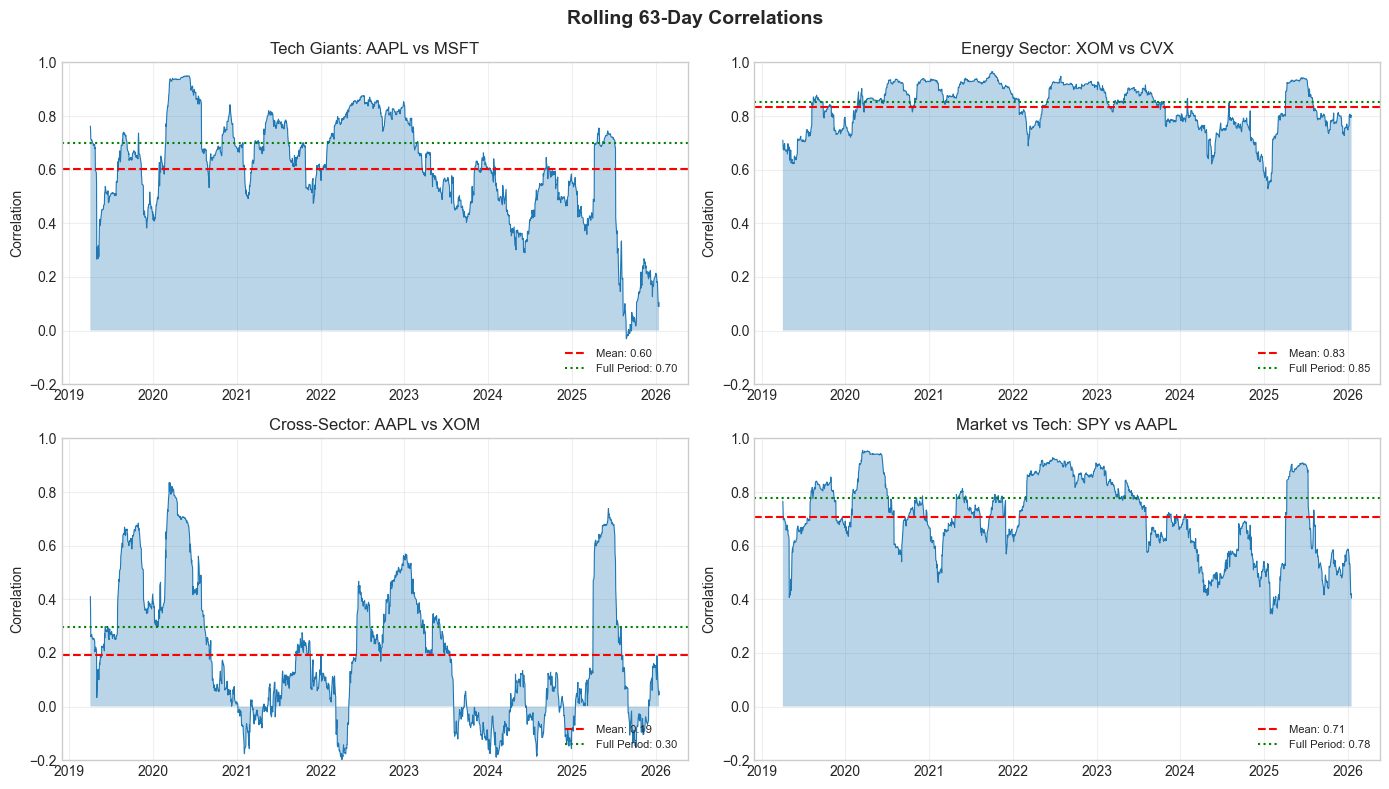


CORRELATION REGIME ANALYSIS: AAPL vs MSFT
Average Correlation: 0.604
Correlation Range: -0.031 to 0.950
Standard Deviation: 0.200

High Correlation Days (>0.8): 288
Low Correlation Days (<0.5): 453


In [13]:
# Calculate rolling correlations
WINDOW = 63  # ~3 months

# Key pairs to analyze
pairs = [
    ('AAPL', 'MSFT', 'Tech Giants'),
    ('XOM', 'CVX', 'Energy Sector'),
    ('AAPL', 'XOM', 'Cross-Sector'),
    ('SPY', 'AAPL', 'Market vs Tech')
]

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for idx, (asset1, asset2, title) in enumerate(pairs):
    rolling_corr = returns[asset1].rolling(WINDOW).corr(returns[asset2])
    
    ax = axes[idx]
    ax.plot(rolling_corr.index, rolling_corr.values, linewidth=0.8)
    ax.axhline(y=rolling_corr.mean(), color='r', linestyle='--', 
               label=f'Mean: {rolling_corr.mean():.2f}')
    ax.axhline(y=corr_matrix.loc[asset1, asset2], color='g', linestyle=':', 
               label=f'Full Period: {corr_matrix.loc[asset1, asset2]:.2f}')
    ax.fill_between(rolling_corr.index, rolling_corr.values, alpha=0.3)
    ax.set_title(f'{title}: {asset1} vs {asset2}')
    ax.set_ylabel('Correlation')
    ax.set_ylim(-0.2, 1.0)
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Rolling {WINDOW}-Day Correlations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify correlation regimes
print("\n" + "=" * 60)
print("CORRELATION REGIME ANALYSIS: AAPL vs MSFT")
print("=" * 60)

rolling_aapl_msft = returns['AAPL'].rolling(WINDOW).corr(returns['MSFT'])
print(f"Average Correlation: {rolling_aapl_msft.mean():.3f}")
print(f"Correlation Range: {rolling_aapl_msft.min():.3f} to {rolling_aapl_msft.max():.3f}")
print(f"Standard Deviation: {rolling_aapl_msft.std():.3f}")

# High vs Low correlation periods
high_corr_periods = (rolling_aapl_msft > 0.8).sum()
low_corr_periods = (rolling_aapl_msft < 0.5).sum()
print(f"\nHigh Correlation Days (>0.8): {high_corr_periods}")
print(f"Low Correlation Days (<0.5): {low_corr_periods}")

## 4. Principal Component Analysis (PCA) for Factor Extraction

**PCA identifies the main factors driving asset returns:**
- PC1 typically represents the "market factor"
- PC2 often captures sector rotations
- Higher PCs capture idiosyncratic movements

**Why PCA Matters:**
1. **Dimensionality Reduction**: Summarize 10+ assets with 2-3 factors
2. **Risk Decomposition**: Understand what drives portfolio variance
3. **Factor Models**: Build statistical arbitrage strategies

PCA - EXPLAINED VARIANCE
PC       Variance %   Cumulative %
-----------------------------------
PC1          56.54%         56.54%
PC2          18.11%         74.65%
PC3           6.65%         81.30%
PC4           4.69%         85.99%
PC5           3.73%         89.72%
PC6           3.63%         93.35%
PC7           2.74%         96.09%
PC8           1.73%         97.82%
PC9           1.42%         99.24%
PC10          0.76%        100.00%

First 3 PCs explain 81.3% of variance
First 5 PCs explain 89.7% of variance


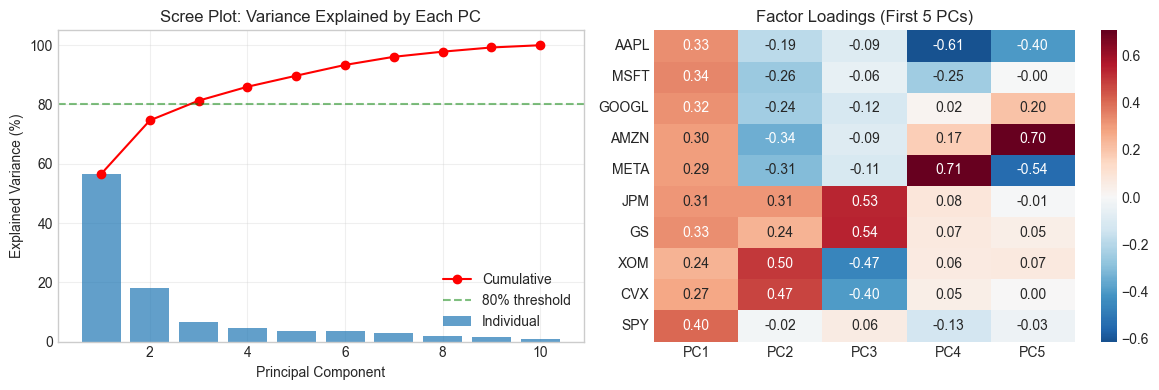

In [14]:
# Standardize returns for PCA
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns)

# Apply PCA
pca = PCA()
pca.fit(returns_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print("=" * 60)
print("PCA - EXPLAINED VARIANCE")
print("=" * 60)
print(f"{'PC':<6} {'Variance %':>12} {'Cumulative %':>14}")
print("-" * 35)
for i, (var, cum) in enumerate(zip(explained_var, cumulative_var)):
    print(f"PC{i+1:<4} {var*100:>11.2f}% {cum*100:>13.2f}%")

print(f"\nFirst 3 PCs explain {cumulative_var[2]*100:.1f}% of variance")
print(f"First 5 PCs explain {cumulative_var[4]*100:.1f}% of variance")

# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Scree plot
axes[0].bar(range(1, len(explained_var)+1), explained_var*100, alpha=0.7, label='Individual')
axes[0].plot(range(1, len(cumulative_var)+1), cumulative_var*100, 'ro-', label='Cumulative')
axes[0].axhline(y=80, color='g', linestyle='--', alpha=0.5, label='80% threshold')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance (%)')
axes[0].set_title('Scree Plot: Variance Explained by Each PC')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Factor loadings heatmap
loadings = pd.DataFrame(
    pca.components_[:5].T,
    columns=[f'PC{i+1}' for i in range(5)],
    index=TICKERS
)

sns.heatmap(loadings, annot=True, cmap='RdBu_r', center=0, fmt='.2f', ax=axes[1])
axes[1].set_title('Factor Loadings (First 5 PCs)')

plt.tight_layout()
plt.show()

In [15]:
# Interpret the factors
print("=" * 60)
print("FACTOR INTERPRETATION")
print("=" * 60)

# PC1 - Market Factor
pc1_loadings = loadings['PC1'].sort_values(ascending=False)
print("\nPC1 (Market Factor - 56.5% variance):")
print("  All stocks load positively → Market-wide movements")
print(f"  Highest: {pc1_loadings.index[0]} ({pc1_loadings.iloc[0]:.2f})")
print(f"  Lowest:  {pc1_loadings.index[-1]} ({pc1_loadings.iloc[-1]:.2f})")

# PC2 - Sector Rotation
pc2_loadings = loadings['PC2'].sort_values(ascending=False)
print("\nPC2 (Sector Rotation - 18.1% variance):")
print("  Energy (XOM, CVX) vs Tech (AMZN, META)")
print(f"  Energy load: XOM={loadings.loc['XOM','PC2']:.2f}, CVX={loadings.loc['CVX','PC2']:.2f}")
print(f"  Tech load: AMZN={loadings.loc['AMZN','PC2']:.2f}, META={loadings.loc['META','PC2']:.2f}")

# PC3 - Financial Factor
print("\nPC3 (Financial Sector - 6.7% variance):")
print(f"  Banks load positively: JPM={loadings.loc['JPM','PC3']:.2f}, GS={loadings.loc['GS','PC3']:.2f}")
print("  Captures banking sector specific movements")

# Reconstruct returns using top 3 PCs
n_components = 3
pca_reduced = PCA(n_components=n_components)
pc_scores = pca_reduced.fit_transform(returns_scaled)

# Calculate residuals (idiosyncratic returns)
reconstructed = pca_reduced.inverse_transform(pc_scores)
residuals = returns_scaled - reconstructed

print("\n" + "=" * 60)
print("SYSTEMATIC vs IDIOSYNCRATIC RISK")
print("=" * 60)
for i, ticker in enumerate(TICKERS):
    total_var = np.var(returns_scaled[:, i])
    residual_var = np.var(residuals[:, i])
    systematic_pct = (1 - residual_var/total_var) * 100
    print(f"{ticker}: {systematic_pct:.1f}% systematic, {100-systematic_pct:.1f}% idiosyncratic")

FACTOR INTERPRETATION

PC1 (Market Factor - 56.5% variance):
  All stocks load positively → Market-wide movements
  Highest: SPY (0.40)
  Lowest:  XOM (0.24)

PC2 (Sector Rotation - 18.1% variance):
  Energy (XOM, CVX) vs Tech (AMZN, META)
  Energy load: XOM=0.50, CVX=0.47
  Tech load: AMZN=-0.34, META=-0.31

PC3 (Financial Sector - 6.7% variance):
  Banks load positively: JPM=0.53, GS=0.54
  Captures banking sector specific movements

SYSTEMATIC vs IDIOSYNCRATIC RISK
AAPL: 68.3% systematic, 31.7% idiosyncratic
MSFT: 78.1% systematic, 21.9% idiosyncratic
GOOGL: 71.0% systematic, 29.0% idiosyncratic
AMZN: 71.3% systematic, 28.7% idiosyncratic
META: 65.1% systematic, 34.9% idiosyncratic
JPM: 91.0% systematic, 9.0% idiosyncratic
GS: 90.5% systematic, 9.5% idiosyncratic
XOM: 92.8% systematic, 7.2% idiosyncratic
CVX: 92.1% systematic, 7.9% idiosyncratic
SPY: 92.8% systematic, 7.2% idiosyncratic


## 5. Interview-Style Challenge: Correlation Matrix Properties

**Common Interview Question**: What properties must a valid correlation matrix satisfy?

1. **Symmetric**: $\rho_{ij} = \rho_{ji}$
2. **Diagonal = 1**: $\rho_{ii} = 1$
3. **Bounded**: $-1 \leq \rho_{ij} \leq 1$
4. **Positive Semi-Definite**: All eigenvalues ≥ 0

In [16]:
def validate_correlation_matrix(corr_matrix):
    """
    Validate that a matrix satisfies correlation matrix properties.
    Returns: dict with validation results
    """
    results = {}
    
    # 1. Check symmetry
    results['symmetric'] = np.allclose(corr_matrix, corr_matrix.T)
    
    # 2. Check diagonal equals 1
    results['diagonal_ones'] = np.allclose(np.diag(corr_matrix), 1.0)
    
    # 3. Check bounds [-1, 1]
    results['bounded'] = (corr_matrix.min().min() >= -1.0) and (corr_matrix.max().max() <= 1.0)
    
    # 4. Check positive semi-definiteness
    eigenvalues = np.linalg.eigvalsh(corr_matrix)
    results['positive_semidefinite'] = all(eigenvalues >= -1e-10)  # Small tolerance
    results['min_eigenvalue'] = eigenvalues.min()
    
    return results

print("=" * 60)
print("CORRELATION MATRIX VALIDATION")
print("=" * 60)

validation = validate_correlation_matrix(corr_matrix.values)
for prop, value in validation.items():
    if prop == 'min_eigenvalue':
        print(f"Minimum Eigenvalue: {value:.6f}")
    else:
        status = "✓ PASS" if value else "✗ FAIL"
        print(f"{prop.replace('_', ' ').title()}: {status}")

# Show eigenvalue spectrum
eigenvalues = np.linalg.eigvalsh(corr_matrix.values)
print("\n" + "=" * 60)
print("EIGENVALUE SPECTRUM")
print("=" * 60)
for i, ev in enumerate(sorted(eigenvalues, reverse=True)):
    pct = ev / sum(eigenvalues) * 100
    bar = "█" * int(pct/2)
    print(f"λ{i+1}: {ev:>6.3f} ({pct:>5.1f}%) {bar}")

CORRELATION MATRIX VALIDATION
Symmetric: ✓ PASS
Diagonal Ones: ✓ PASS
Bounded: ✓ PASS
Positive Semidefinite: ✓ PASS
Minimum Eigenvalue: 0.075793

EIGENVALUE SPECTRUM
λ1:  5.654 ( 56.5%) ████████████████████████████
λ2:  1.811 ( 18.1%) █████████
λ3:  0.665 (  6.6%) ███
λ4:  0.469 (  4.7%) ██
λ5:  0.373 (  3.7%) █
λ6:  0.363 (  3.6%) █
λ7:  0.274 (  2.7%) █
λ8:  0.173 (  1.7%) 
λ9:  0.142 (  1.4%) 
λ10:  0.076 (  0.8%) 


## 📝 Key Takeaways

### What We Learned
1. **Correlation ≠ Covariance**: Correlation is normalized (-1 to 1), covariance depends on scale
2. **Diversification Benefit**: Lower correlations → Lower portfolio risk (energy vs tech ~0.16)
3. **Correlations Are Dynamic**: Rolling correlations range from -0.03 to 0.95 for AAPL-MSFT
4. **PCA Factor Structure**: PC1 (market) explains 57%, PC2 (sector rotation) explains 18%
5. **Matrix Properties**: Valid correlation matrices must be symmetric, bounded, and positive semi-definite

### Interview Prep 🎯
- **Q**: Why might diversification fail during a crisis?  
  **A**: Correlations increase during market stress (correlation breakdown)
  
- **Q**: How many factors do you need for a good factor model?  
  **A**: 3 PCs capture 81% of variance; diminishing returns after that

### Tomorrow's Preview
Day 5: Visualization & EDA for Financial Data - Matplotlib/Seaborn for price charts, distributions, and correlation heatmaps

# Day 04: Correlation, Covariance & Factor Analysis

## 🎯 Learning Objectives

By the end of this notebook, you will be able to:

1. **Calculate and interpret correlation matrices** for multi-asset portfolios
2. **Understand covariance** and its role in portfolio risk measurement
3. **Compute portfolio variance** using the covariance matrix
4. **Apply PCA (Principal Component Analysis)** for factor extraction
5. **Implement rolling correlations** to track regime changes
6. **Identify correlation breakdown** during market stress

## 📚 Key Concepts

- **Correlation**: Measures linear relationship between two variables (-1 to +1)
- **Covariance**: Measures how two variables move together (unbounded)
- **Portfolio Variance**: σ²_p = w'Σw where Σ is the covariance matrix
- **PCA**: Dimensionality reduction to identify underlying factors
- **Correlation Regime**: How correlations change during different market conditions

In [1]:
# =============================================================================
# Setup and Imports
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 15)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(precision=4)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [2]:
# =============================================================================
# Load Market Data
# =============================================================================
# Load adjusted close prices
prices = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                     index_col=0, parse_dates=True)

# Select a subset of stocks for analysis (diverse sectors)
selected_tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'BAC', 'XOM', 'CVX', 
                    'JNJ', 'PFE', 'PG', 'KO', 'DIS', 'BA', 'CAT', 'GE']

# Filter to available tickers
available_tickers = [t for t in selected_tickers if t in prices.columns]
prices = prices[available_tickers].dropna()

# Calculate daily returns
returns = prices.pct_change().dropna()

print(f"📊 Data Shape: {prices.shape}")
print(f"📅 Date Range: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"🏢 Stocks: {list(prices.columns)}")
print(f"\n📈 Sample Returns Statistics:")
returns.describe().round(4)

📊 Data Shape: (1771, 14)
📅 Date Range: 2019-01-02 to 2026-01-16
🏢 Stocks: ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'BAC', 'XOM', 'CVX', 'JNJ', 'PFE', 'PG', 'KO', 'DIS', 'BA', 'CAT']

📈 Sample Returns Statistics:


,AAPL,MSFT,GOOGL,JPM,BAC,XOM,CVX,JNJ,PFE,PG,KO,DIS,BA,CAT
count,1770.0000,1770.0000,1770.0000,1770.0000,1770.0000,1770.0000,1770.0000,1770.0000,1770.0000,1770.0000,1770.0000,1770.0000,1770.0000,1770.0000
mean,0.0013,0.0011,0.0012,0.0009,0.0007,0.0007,0.0006,0.0005,0.0001,0.0004,0.0004,0.0002,0.0003,0.0012
std,0.0195,0.0178,0.0197,0.0188,0.0208,0.0196,0.0203,0.0121,0.0165,0.0126,0.0125,0.0201,0.0294,0.0200
min,-0.1286,-0.1474,-0.1163,-0.1496,-0.1540,-0.1222,-0.2212,-0.0759,-0.0773,-0.0874,-0.0967,-0.1316,-0.2385,-0.1428
25%,-0.0078,-0.0074,-0.0085,-0.0077,-0.0091,-0.0095,-0.0081,-0.0053,-0.0091,-0.0055,-0.0053,-0.0088,-0.0126,-0.0090
50%,0.0013,0.0012,0.0015,0.0011,0.0006,0.0006,0.0009,0.0005,-0.0003,0.0007,0.0007,-0.0001,-0.0001,0.0010
75%,0.0114,0.0102,0.0113,0.0096,0.0106,0.0111,0.0094,0.0062,0.0083,0.0069,0.0063,0.0092,0.0129,0.0118
max,0.1533,0.1422,0.1022,0.1801,0.1780,0.1269,0.2274,0.0800,0.1086,0.1201,0.0648,0.1441,0.2432,0.1163


## 1️⃣ Correlation Matrix Analysis

### Understanding Correlation
- **Pearson Correlation**: Measures linear relationship between returns
- **Range**: -1 (perfect negative) to +1 (perfect positive)
- **Key Insight**: Diversification works best when correlations are low

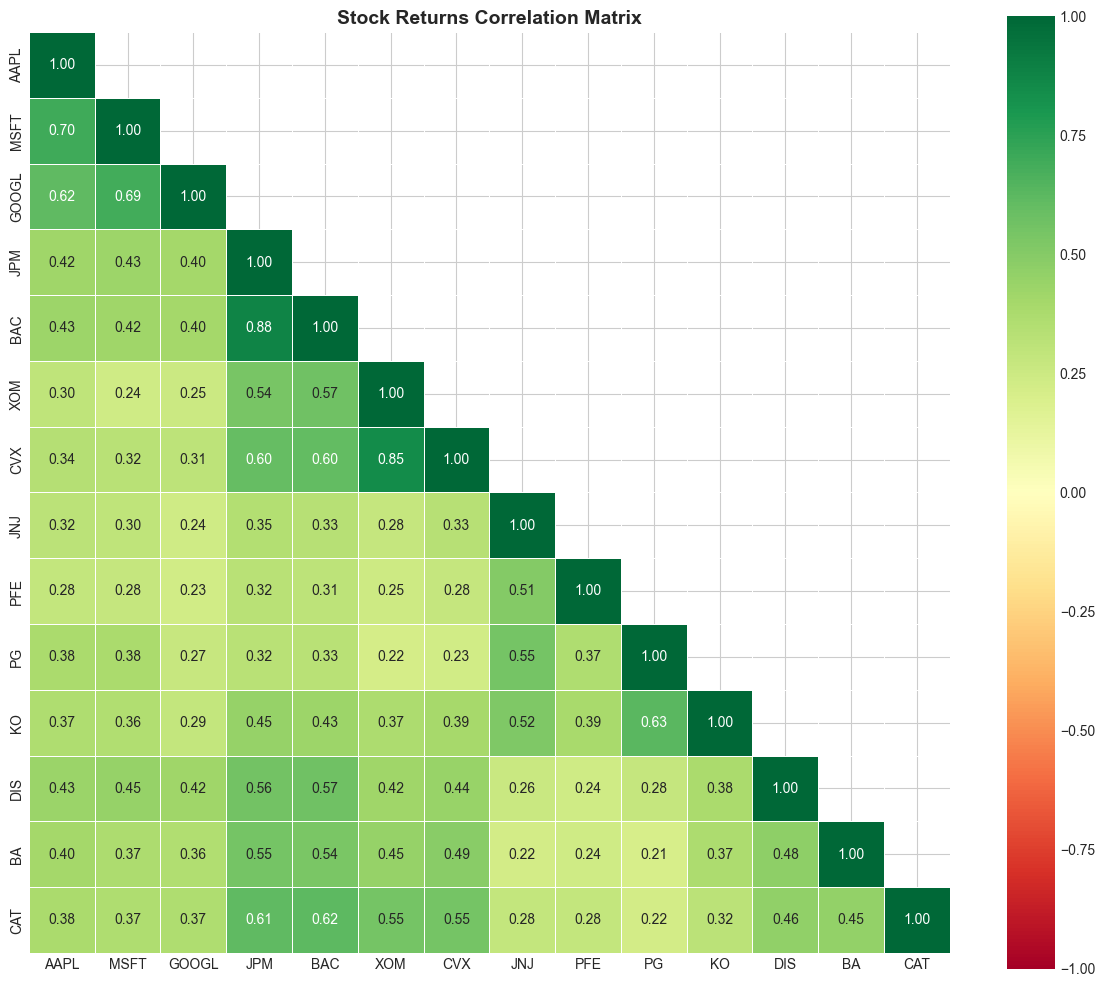

🔝 Top 5 Most Correlated Pairs:
Stock1 Stock2  Correlation
   JPM    BAC       0.8802
   XOM    CVX       0.8508
  AAPL   MSFT       0.6993
  MSFT  GOOGL       0.6931
    PG     KO       0.6255

🔻 Top 5 Least Correlated Pairs:
Stock1 Stock2  Correlation
   CVX     PG       0.2308
   JNJ     BA       0.2226
    PG    CAT       0.2205
   XOM     PG       0.2186
    PG     BA       0.2063


In [3]:
# =============================================================================
# Calculate and Visualize Correlation Matrix
# =============================================================================

# Calculate correlation matrix
corr_matrix = returns.corr()

# Create a heatmap
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # Upper triangle mask
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdYlGn', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, ax=ax)
plt.title('Stock Returns Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highest and lowest correlations
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append({
            'Stock1': corr_matrix.columns[i],
            'Stock2': corr_matrix.columns[j],
            'Correlation': corr_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('Correlation', ascending=False)
print("🔝 Top 5 Most Correlated Pairs:")
print(corr_df.head().to_string(index=False))
print("\n🔻 Top 5 Least Correlated Pairs:")
print(corr_df.tail().to_string(index=False))

## 2️⃣ Covariance Matrix & Portfolio Variance

### Key Formula
**Portfolio Variance**: σ²_p = w'Σw

Where:
- w = weight vector
- Σ = covariance matrix
- σ²_p = portfolio variance

In [4]:
# =============================================================================
# Covariance Matrix and Portfolio Risk
# =============================================================================

# Calculate annualized covariance matrix (252 trading days)
cov_matrix = returns.cov() * 252

print("📊 Annualized Covariance Matrix (sample):")
print(cov_matrix.iloc[:5, :5].round(4))

# Relationship between correlation and covariance
# Cov(X,Y) = Corr(X,Y) * σ_X * σ_Y
print("\n📐 Verifying Cov = Corr × σ_X × σ_Y:")
stock1, stock2 = returns.columns[0], returns.columns[1]
corr_12 = corr_matrix.loc[stock1, stock2]
std_1 = returns[stock1].std() * np.sqrt(252)
std_2 = returns[stock2].std() * np.sqrt(252)
cov_calculated = corr_12 * std_1 * std_2
cov_actual = cov_matrix.loc[stock1, stock2]
print(f"  {stock1} vs {stock2}:")
print(f"  Calculated Cov: {cov_calculated:.6f}")
print(f"  Actual Cov:     {cov_actual:.6f}")

📊 Annualized Covariance Matrix (sample):
        AAPL   MSFT  GOOGL    JPM    BAC
AAPL  0.0961 0.0614 0.0598 0.0390 0.0438
MSFT  0.0614 0.0802 0.0614 0.0362 0.0392
GOOGL 0.0598 0.0614 0.0980 0.0375 0.0412
JPM   0.0390 0.0362 0.0375 0.0893 0.0868
BAC   0.0438 0.0392 0.0412 0.0868 0.1089

📐 Verifying Cov = Corr × σ_X × σ_Y:
  AAPL vs MSFT:
  Calculated Cov: 0.061412
  Actual Cov:     0.061412


In [5]:
# =============================================================================
# Portfolio Variance Calculation
# =============================================================================

def portfolio_stats(weights, returns, cov_matrix):
    """
    Calculate portfolio return and volatility.
    
    Parameters:
    -----------
    weights : array-like
        Portfolio weights
    returns : DataFrame
        Daily returns
    cov_matrix : DataFrame
        Annualized covariance matrix
        
    Returns:
    --------
    tuple: (annual_return, annual_volatility, sharpe_ratio)
    """
    weights = np.array(weights)
    
    # Portfolio return (annualized)
    port_return = np.sum(returns.mean() * weights) * 252
    
    # Portfolio volatility: sqrt(w'Σw)
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    port_volatility = np.sqrt(port_variance)
    
    # Sharpe ratio (assuming 0% risk-free rate)
    sharpe = port_return / port_volatility
    
    return port_return, port_volatility, sharpe

# Equal-weighted portfolio
n_stocks = len(returns.columns)
equal_weights = np.ones(n_stocks) / n_stocks

ret, vol, sharpe = portfolio_stats(equal_weights, returns, cov_matrix)
print("📊 Equal-Weighted Portfolio Statistics:")
print(f"   Expected Annual Return: {ret:.2%}")
print(f"   Annual Volatility:      {vol:.2%}")
print(f"   Sharpe Ratio:           {sharpe:.3f}")

# Compare with individual stock volatilities
print("\n📈 Individual Stock Volatilities (Annualized):")
individual_vols = returns.std() * np.sqrt(252)
print(individual_vols.round(4).to_string())

# Diversification benefit
avg_individual_vol = individual_vols.mean()
print(f"\n✨ Diversification Benefit:")
print(f"   Average Individual Vol: {avg_individual_vol:.2%}")
print(f"   Portfolio Vol:          {vol:.2%}")
print(f"   Reduction:              {(avg_individual_vol - vol)/avg_individual_vol:.1%}")

📊 Equal-Weighted Portfolio Statistics:
   Expected Annual Return: 17.50%
   Annual Volatility:      19.97%
   Sharpe Ratio:           0.877

📈 Individual Stock Volatilities (Annualized):
AAPL    0.3100
MSFT    0.2833
GOOGL   0.3130
JPM     0.2989
BAC     0.3300
XOM     0.3117
CVX     0.3223
JNJ     0.1923
PFE     0.2616
PG      0.2007
KO      0.1985
DIS     0.3195
BA      0.4669
CAT     0.3171

✨ Diversification Benefit:
   Average Individual Vol: 29.47%
   Portfolio Vol:          19.97%
   Reduction:              32.2%


## 3️⃣ Principal Component Analysis (PCA) for Factor Extraction

### Why PCA in Finance?
- **Identify common factors** driving stock returns (market, sector, etc.)
- **Reduce dimensionality** for portfolio construction
- **First PC often captures market risk** (systematic risk)
- **Subsequent PCs capture sector/style factors**

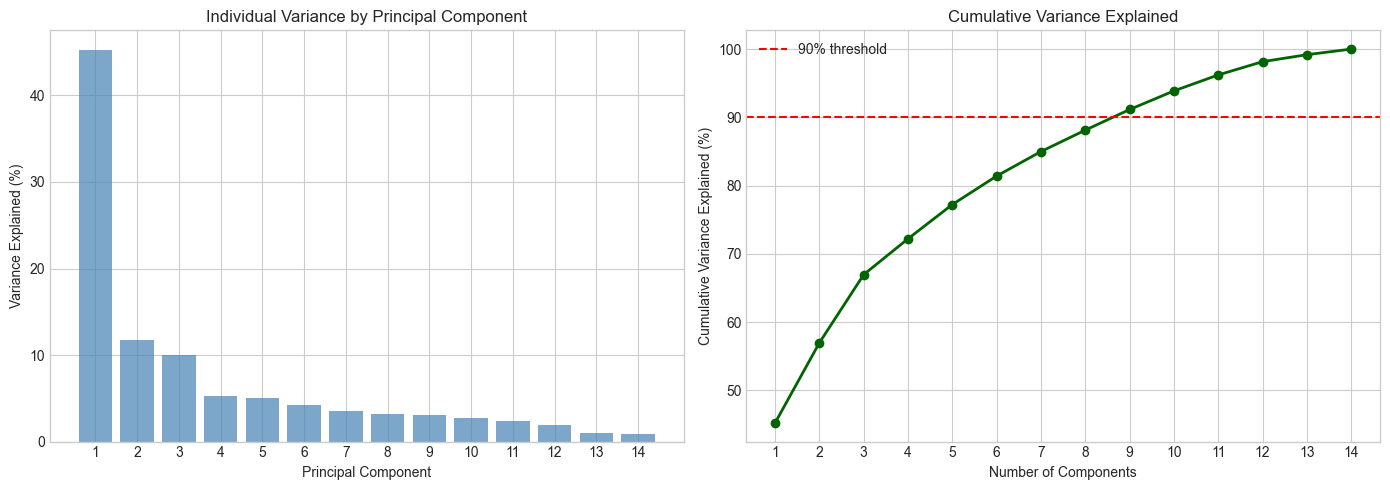

📊 PCA Summary:
   PC1 explains: 45.3% of variance (Market Factor)
   PC2 explains: 11.7% of variance
   Components for 90% variance: 9


In [6]:
# =============================================================================
# PCA Analysis
# =============================================================================

# Standardize returns for PCA
scaler = StandardScaler()
returns_standardized = scaler.fit_transform(returns)

# Fit PCA
pca = PCA()
pca.fit(returns_standardized)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot - individual variance
axes[0].bar(range(1, len(explained_var)+1), explained_var * 100, 
            color='steelblue', alpha=0.7)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained (%)')
axes[0].set_title('Individual Variance by Principal Component')
axes[0].set_xticks(range(1, len(explained_var)+1))

# Line plot - cumulative variance
axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var * 100, 
             'o-', color='darkgreen', linewidth=2)
axes[1].axhline(y=90, color='r', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained (%)')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].set_xticks(range(1, len(cumulative_var)+1))

plt.tight_layout()
plt.show()

# How many components to explain 90% variance?
n_components_90 = np.argmax(cumulative_var >= 0.90) + 1
print(f"📊 PCA Summary:")
print(f"   PC1 explains: {explained_var[0]:.1%} of variance (Market Factor)")
print(f"   PC2 explains: {explained_var[1]:.1%} of variance")
print(f"   Components for 90% variance: {n_components_90}")

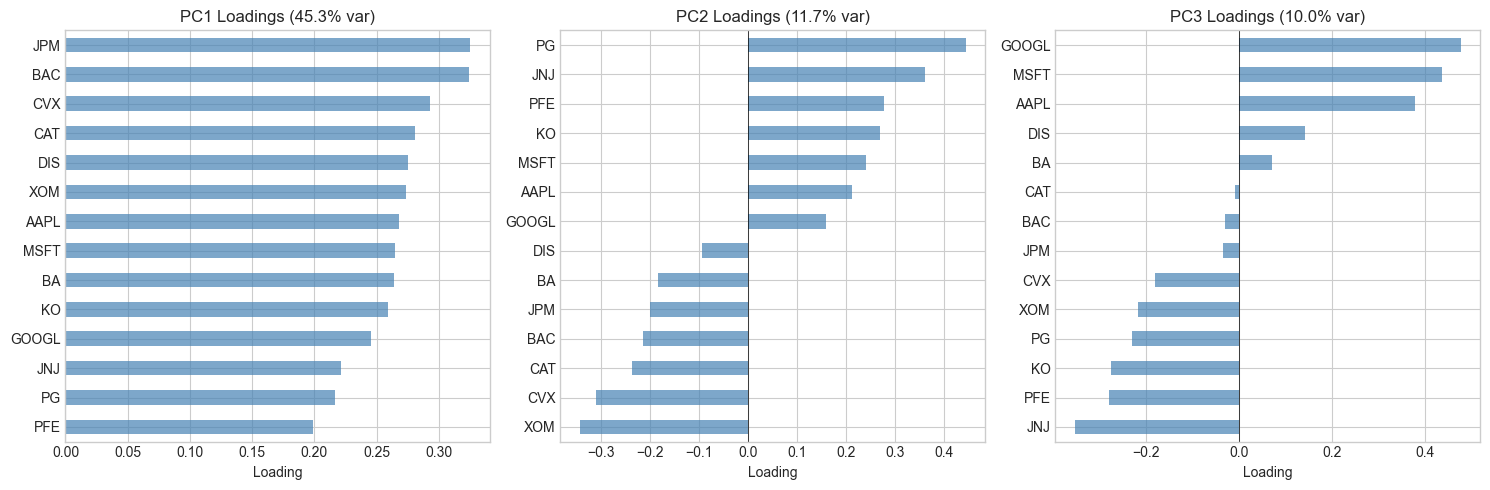

📊 Interpretation:
   PC1: Market factor - all stocks have similar positive loadings
   PC2-3: Sector/style factors - differentiate between groups


In [7]:
# =============================================================================
# Factor Loadings Analysis
# =============================================================================

# Get factor loadings (components)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(returns.columns))],
    index=returns.columns
)

# Visualize first 3 components
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    loadings[f'PC{i+1}'].sort_values().plot(kind='barh', ax=ax, 
                                             color='steelblue', alpha=0.7)
    ax.set_title(f'PC{i+1} Loadings ({explained_var[i]:.1%} var)')
    ax.axvline(x=0, color='black', linewidth=0.5)
    ax.set_xlabel('Loading')

plt.tight_layout()
plt.show()

print("📊 Interpretation:")
print("   PC1: Market factor - all stocks have similar positive loadings")
print("   PC2-3: Sector/style factors - differentiate between groups")

## 4️⃣ Rolling Correlations & Regime Detection

### Why Rolling Correlations?
- **Correlations are NOT constant** over time
- **Regime changes**: Correlations typically spike during market stress
- **"Correlations go to 1 in a crisis"** - diversification fails when needed most
- **Rolling window**: 60-252 days typically used

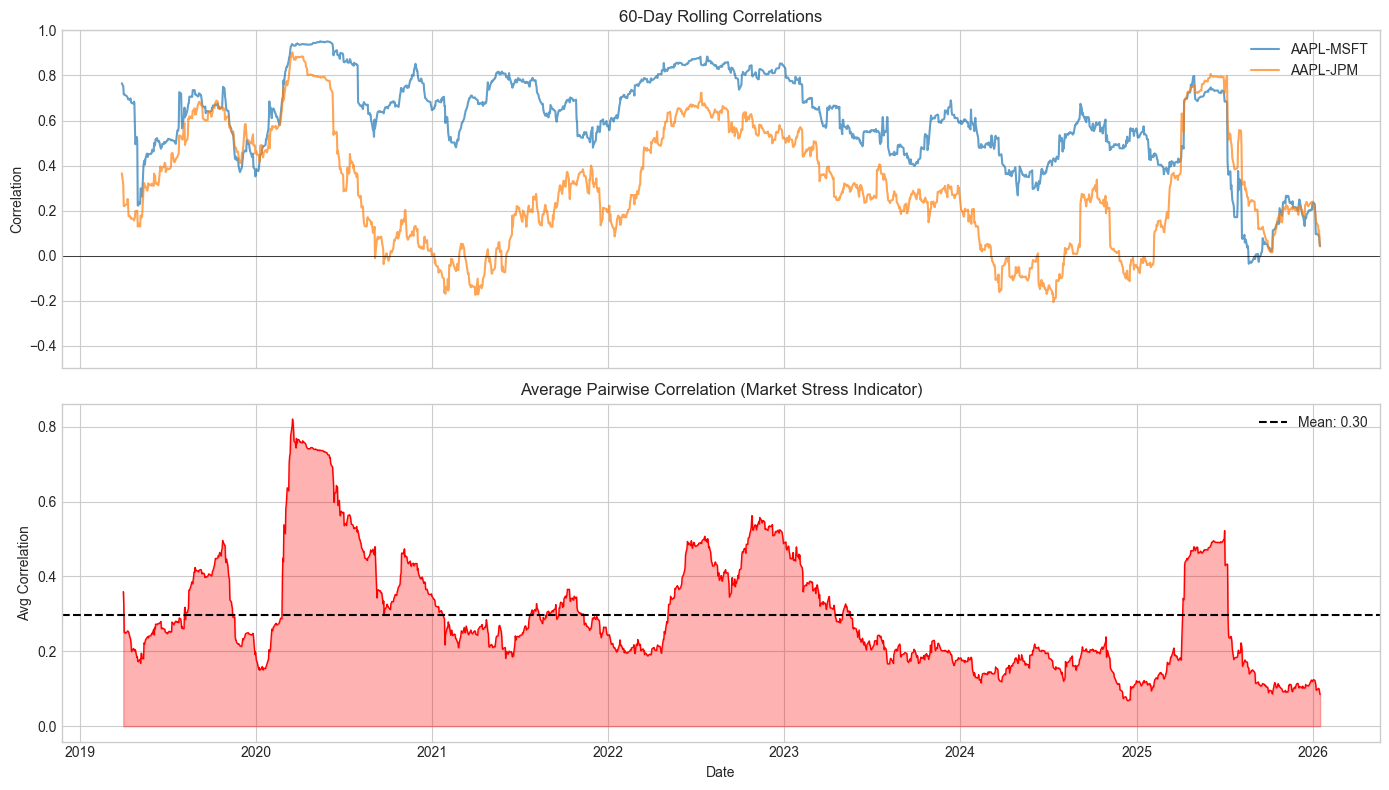

📊 Average Correlation Statistics:
   Mean: 0.297
   Std:  0.154
   Max:  0.820 (potential stress period)
   Min:  0.068


In [8]:
# =============================================================================
# Rolling Correlation Analysis
# =============================================================================

def rolling_correlation(returns, stock1, stock2, window=60):
    """Calculate rolling correlation between two stocks."""
    return returns[stock1].rolling(window).corr(returns[stock2])

# Calculate rolling correlations for select pairs
window = 60  # 60-day rolling window
pairs = [
    (returns.columns[0], returns.columns[1]),
    (returns.columns[0], returns.columns[3]) if len(returns.columns) > 3 else (returns.columns[0], returns.columns[1])
]

# Average correlation across all pairs (measure of market stress)
def rolling_avg_correlation(returns, window=60):
    """Calculate average pairwise correlation over rolling window."""
    avg_corr = []
    for i in range(window, len(returns)):
        window_returns = returns.iloc[i-window:i]
        corr_mat = window_returns.corr()
        # Get upper triangle (excluding diagonal)
        upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
        avg_corr.append(upper_tri.stack().mean())
    return pd.Series(avg_corr, index=returns.index[window:])

avg_corr = rolling_avg_correlation(returns, window)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot individual pair correlations
for stock1, stock2 in pairs:
    roll_corr = rolling_correlation(returns, stock1, stock2, window)
    axes[0].plot(roll_corr.index, roll_corr.values, label=f'{stock1}-{stock2}', alpha=0.7)

axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_ylabel('Correlation')
axes[0].set_title(f'{window}-Day Rolling Correlations')
axes[0].legend(loc='upper right')
axes[0].set_ylim(-0.5, 1)

# Plot average correlation
axes[1].fill_between(avg_corr.index, avg_corr.values, alpha=0.3, color='red')
axes[1].plot(avg_corr.index, avg_corr.values, color='red', linewidth=1)
axes[1].axhline(y=avg_corr.mean(), color='black', linestyle='--', 
                label=f'Mean: {avg_corr.mean():.2f}')
axes[1].set_ylabel('Avg Correlation')
axes[1].set_xlabel('Date')
axes[1].set_title('Average Pairwise Correlation (Market Stress Indicator)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"📊 Average Correlation Statistics:")
print(f"   Mean: {avg_corr.mean():.3f}")
print(f"   Std:  {avg_corr.std():.3f}")
print(f"   Max:  {avg_corr.max():.3f} (potential stress period)")
print(f"   Min:  {avg_corr.min():.3f}")

## 5️⃣ Correlation Breakdown During Market Stress

### Key Insight
During market downturns:
- Correlations typically increase
- Diversification benefits decrease
- Risk models may underestimate portfolio risk

📊 Correlation Comparison:
   Normal Periods Avg Correlation: 0.278
   Stress Periods Avg Correlation: 0.406
   Increase During Stress: 0.128


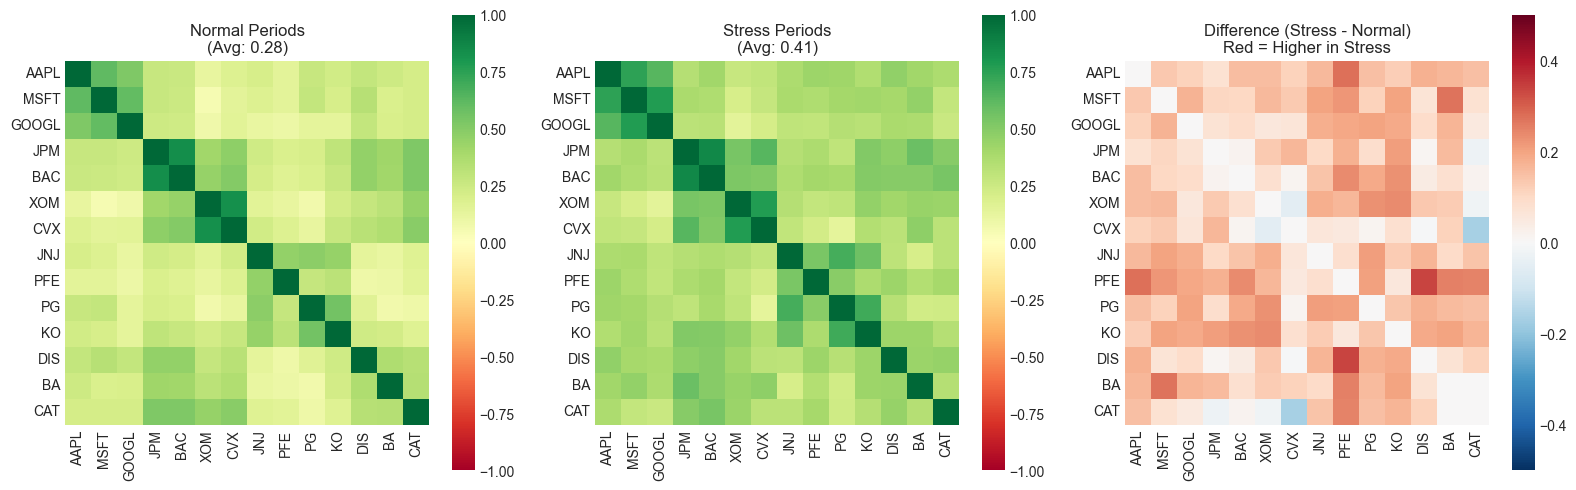


⚠️ Key Takeaway: Most correlations increase during market stress,
   reducing diversification benefits precisely when they're needed most.


In [9]:
# =============================================================================
# Stress vs Normal Period Correlation Comparison
# =============================================================================

# Calculate portfolio returns (equal-weighted)
portfolio_returns = returns.mean(axis=1)

# Define stress periods as bottom 10% of returns
stress_threshold = portfolio_returns.quantile(0.10)
stress_mask = portfolio_returns < stress_threshold

# Split data
stress_returns = returns[stress_mask]
normal_returns = returns[~stress_mask]

# Calculate correlations for each period
stress_corr = stress_returns.corr()
normal_corr = normal_returns.corr()

# Average correlation in each regime
def avg_correlation(corr_matrix):
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    return upper_tri.stack().mean()

print("📊 Correlation Comparison:")
print(f"   Normal Periods Avg Correlation: {avg_correlation(normal_corr):.3f}")
print(f"   Stress Periods Avg Correlation: {avg_correlation(stress_corr):.3f}")
print(f"   Increase During Stress: {(avg_correlation(stress_corr) - avg_correlation(normal_corr)):.3f}")

# Visualize the difference
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Normal correlation
sns.heatmap(normal_corr, ax=axes[0], cmap='RdYlGn', center=0, vmin=-1, vmax=1,
            annot=False, square=True)
axes[0].set_title(f'Normal Periods\n(Avg: {avg_correlation(normal_corr):.2f})')

# Stress correlation
sns.heatmap(stress_corr, ax=axes[1], cmap='RdYlGn', center=0, vmin=-1, vmax=1,
            annot=False, square=True)
axes[1].set_title(f'Stress Periods\n(Avg: {avg_correlation(stress_corr):.2f})')

# Difference
diff_corr = stress_corr - normal_corr
sns.heatmap(diff_corr, ax=axes[2], cmap='RdBu_r', center=0, vmin=-0.5, vmax=0.5,
            annot=False, square=True)
axes[2].set_title('Difference (Stress - Normal)\nRed = Higher in Stress')

plt.tight_layout()
plt.show()

print("\n⚠️ Key Takeaway: Most correlations increase during market stress,")
print("   reducing diversification benefits precisely when they're needed most.")

## 📝 Summary & Key Takeaways

### What We Learned:
1. **Correlation Matrix**: Essential for understanding asset relationships
2. **Covariance & Portfolio Variance**: Foundation of portfolio risk measurement
3. **PCA**: PC1 captures market risk, subsequent PCs capture factor exposures
4. **Rolling Correlations**: Correlations change over time - not constant!
5. **Correlation Breakdown**: Diversification fails during stress periods

### Interview Topics:
- How to calculate portfolio variance from covariance matrix
- Why correlations increase during market stress
- Interpreting PCA factor loadings
- Difference between correlation and covariance

### Next Steps:
- Day 05: Visualization and EDA for financial data
- Apply these concepts to portfolio construction